In [79]:
%matplotlib inline

import jax.numpy as jnp
from jax import value_and_grad
from jax import random
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as snb


from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


# we want to use 64 bit floating precision
import jax
jax.config.update("jax_enable_x64", True)

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.25)


# 02477 Bayesian Machine Learning: Exercise 5

The purpose of this exercise is to
- learn how to sample from a multivariate Gaussian distribution
- become familiar with covariance functions, especially stationary covariance functions such as the squared exponential and Matérn family and to understand their properties and hyperparameters
- become familiar with Gaussian processes and learn to use them as prior distribution for latent functions in regression settings


**Content**

- Part 1: Sampling from a multivariate Gaussian distribution
- Part 2: Stationary covariance functions
- Part 3: Non-linear regression using Gaussian processes
- Part 4: Hyperparameter optimization using the marginal likelihood
- Part 5: Analysing the bike sharing data set


**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

# Introduction

When we worked with parametric models such as linear regression and logistic regression, we assigned prior distributions on the weights $\mathbf{w}$ of the models. In contrast, we can think of Gaussian processes as prior distributions directly on the function space

$$\begin{align*}
f(\mathbf{x}) \sim \mathcal{GP}\left(m(\mathbf{x}) \, , \, k\left(\mathbf{x}, \mathbf{x}'\right)\right)
\end{align*}$$

where $f: \mathbb{R}^D \rightarrow \mathbb{R}$ and $\mathbf{m}(\mathbf{x}) = \mathbb{E}\left[f(\mathbf{x})\right]$, and $\mathbf{k}(\mathbf{x}, \mathbf{x}') = \mathbb{E}\left[\left(f(\mathbf{x})-m(\mathbf{x})\right)\left(f(\mathbf{x'})-m(\mathbf{x'})\right)\right]$ are the **mean function** and **covariance function**, respectively, for $\mathbf{x}, \mathbf{x}' \in \mathbb{R}$.


A Gaussian process is completely specified by its mean and covariance function. Most often we take the mean function to be zero, $m(\mathbf{x}) = 0$, because we don't have any prior information on the mean function:

$$\begin{align*}
f(\mathbf{x}) \sim \mathcal{GP}\left(0 \, , \, k\left(\mathbf{x}, \mathbf{x}'\right)\right), \tag{1}
\end{align*}$$

The **covariance function** (or kernel function) $k(\mathbf{x}, \mathbf{x}')$ thus completely determines the a priori behavior of the latent function $f$. Specifically, the covariance function determines the covariance of the latent function $f$ when evaluated at two different inputs, i.e.

$$\begin{align*}
\text{cov}[f(\mathbf{x}), f(\mathbf{x}')] = k(\mathbf{x}, \mathbf{x}'). \tag{2}
\end{align*}$$


The **squared exponential** covariance function is given by

\begin{align*} 
    k_{\text{SE}}(\mathbf{x}_n, \mathbf{x}_m) = \kappa^2 \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_m\|^2_ 2}{2\ell^2}\right), \tag{3}
\end{align*}

where $\kappa > 0$ and $\ell > 0$ are hyperparameters of the kernel. This specific covariance function is perhaps the most common covariance function used in statistics and machine learning. It is also known as the radial basis function kernel, the gaussian kernel, or the exponentiated quadratic kernel. We will also study two covariance functions from the Matérn family:

$$\begin{align*}
k_{\text{Matern12}}(\mathbf{x}_n, \mathbf{x}_m) &= \kappa^2 \exp\left(-\frac{||\mathbf{x}_n- \mathbf{x}_m||}{\ell}\right)\\
k_{\text{Matern32}}(\mathbf{x}_n, \mathbf{x}_m) &= \kappa^2 \left(1 + \frac{\sqrt{3}||\mathbf{x}_n - \mathbf{x}_m||}{\ell}\right)\exp\left(-\frac{\sqrt{3}||\mathbf{x}_n- \mathbf{x}_m||}{\ell}\right).
\end{align*}
$$




# Part 1:  Sampling from a multivariate Gaussian distribution


To become familiar with covariance functions and understand its properties, we will generate and visualize samples from Gaussian process distributions. Therefore, our first order of business will be to implement a function for generating samples from a Gaussian process prior.


Let $\mathbf{X} = \left\lbrace \mathbf{x}_n \right\rbrace_{n=1}^N $ be a set of points in the real line, i.e. $\mathbf{x}_n \in \mathbb{R}^D$, and let $f: \mathbb{R}^D \rightarrow \mathbb{R}$ be a function. Let $f_n \equiv f(x_n) \in \mathbb{R}$ be the value of the function $f$ evaluated at $x_n \in \mathbb{R}$. Furthermore, let $\mathbf{f} \equiv \left[f_1, f_2, \dots, f_N\right] \in \mathbb{R}^{N \times 1}$ be the vector of function values for each of the points in $\mathbf{X}$, then the Gaussian process prior for $\mathbf{f}$ becomes

$$\begin{align*}
\mathbf{f} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{K}\right), \tag{4}
\end{align*}
$$

where $\mathbf{K} \in \mathbb{R}^{N \times N}$ is the kernel matrix satisfying $\mathbf{K}_{nm} = k(\mathbf{x}_n ,\mathbf{x}_m)$, where $\mathbf{x}_n$ refers to the $n$'th input point, i.e. the $i$'th entry of $\mathbf{X}$.

The **Cholesky decomposition** is sometimes refered to as *matrix square root* and it is really handy matrix decomposition for sampling from a multivariate Gaussian distribution. The Cholesky decomposition of the kernel matrix is given by $\mathbf{K} = \mathbf{L}\mathbf{L}^T$, where $\mathbf{L} \in \mathbb{R}^{N \times N}$ is a lower triangular matrix.

The idea is to generate samples from standardized Gaussian distributions, and then transform those samples into the desired distribution. Let $\mathbf{z} \in \mathbb{R}^{N \times 1}$ be a sample from a standardized multivariate Gaussian distribution, i.e. $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_n)$, where $\mathbf{I}_n$ is the identity matrix of size $N \times N$.

**Task 1.1**: Show that if $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_n)$ and $\mathbf{m} \in \mathbb{R}^{N}$, then $\mathbf{f} = \mathbf{L}\mathbf{z} + \mathbf{m} \sim \mathcal{N}(\mathbf{m}, \mathbf{K})$. 

$$E(L z + m) = m + E(Lz) = LE(z) + m = m$$
$$D(Lz + m) = D(L z) = L D(z) L^T = L I L^T = K$$


 

All real-valued symmetric and positive definite matrices have a unique Cholesky decomposition. However, due to finite precision in computers, the covariance matrices used in Gaussian processes can sometimes have negative eigenvalues in practice and hence fail to be positive definite. A common trick is to add a small positive number $\epsilon > 0$ to the diagonal of the covariance matrix, which will increase the eigenvalues of the covariance matrix $\mathbf{K}$ and hence change the sign of a potential small negative eigenvalue. Hence, in practice we construct the covariance matrix as:

$$
\begin{align*}
\mathbf{K}_{nm}  = k(\mathbf{x}_n, \mathbf{x}_m) + \epsilon \delta(\mathbf{x}_n-\mathbf{x}_m),
\end{align*}
$$

where $\delta(\cdot)$ is **Kronenecker's delta function** defined by 

$$\begin{align*}
\delta(\mathbf{x}_n-\mathbf{x}_m) = \begin{cases} 1 & \text{if}\quad \mathbf{x}_n=\mathbf{x}_m \\ 0 & \text{otherwise} \end{cases}
\end{align*}
$$

We often say we add **jitter** to the covariance matrix. $\epsilon$ should be as small as positive to avoid affecting the results, e.g. a typical number is $\epsilon \approx 10^{-8}$. If $\epsilon$ needs to be significantly bigger, then it is likely that there are some other implementation issues, which should be addressed.

**Task 1.2**: **(optional)** Can you prove that adding jitter increases the eigenvalues of the resulting matrix?




**Task 1.3**: Complete the implementation of the function `generate_samples` below for sampling from a multivariate Gaussian using the method described above. 

*Hints*:
- *The function jnp.linalg.cholesky is handy for computing the Cholesky decomposition of a matrix.*
- *You need to add the jitter before computing the Cholesky decomposition.*
- *The argument `key` is for controlling the random number generator in JaX. Sampling is an inherently stochastic procedure, but the explicit use of such keys allows us to build reproducible code in the sense that if we provide the same key, we get the same output.*

In [80]:
def generate_samples(key, m, K, num_samples, jitter=0):
    """ returns M samples from an Gaussian process with mean m and kernel matrix K. The function generates num_samples of z ~ N(0, I) and transforms them into f  ~ N(m, K) via the Cholesky factorization.

    
    arguments:
        key              -- jax random key for controlling the random number generator
        m                -- mean vector (shape (N,))
        K                -- kernel matrix (shape NxN)
        num_samples      -- number of samples to generate (positive integer)
        jitter           -- amount of jitter (non-negative scalar)
    
    returns 
        f_samples        -- a numpy matrix containing the samples of f (shape N x num_samples)
    """

    # generate samples from N(0, 1) of shape (N, num_samples)
    zs = random.normal(key, shape=(len(K), num_samples))

    ##############################################
    # Your solution goes here
    ##############################################
    L = jnp.linalg.cholesky(K + jnp.identity(K.shape[0]) * jitter)
    f_samples = L @ zs + m[:, None]

    ##############################################
    # End of solution
    ##############################################

    # sanity check of dimensions
    assert f_samples.shape == (len(K), num_samples), f"The shape of f_samples appears wrong. Expected shape ({len(K)}, {num_samples}), but the actual shape was {f_samples.shape}. Please check your code. "
    return f_samples


# sanity check of implementation
key = random.PRNGKey(1)
num_samples = 100000
m = jnp.array([jnp.pi, jnp.sqrt(2)])
V = jnp.array([[0.123, -0.05], [-0.05, 0.123]])
f_samples = generate_samples(key, m, V, num_samples)
assert jnp.linalg.norm(jnp.mean(f_samples, 1)- m) < 1e-2, "The mean of f_samples appears wrong. Please check your code"
assert jnp.linalg.norm(jnp.cov(f_samples) - V) < 1e-2, "The covariance of f_samples appears wrong. Please check your code"

We will use this function in the next section to generate samples from a Gaussian process.

# Part 2:  Stationary covariance functions

Next, we will dive deeper into the covariance functions and their properties. We will focus on so-called **stationary** covariance functions.

The squared exponential kernel is an example of a **stationary** kernel, which means that the covariance function only depends on the difference between two points, i.e. $\tau = \mathbf{x}_n - \mathbf{x}_m$ for two points in the input space $\mathbf{x}_n, \mathbf{x}_m \in \mathbb{R}^D$:

$$\begin{align*}
    k_{\text{SE}}(\mathbf{x}_n, \mathbf{x}_m) = \kappa^2 \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_m\|^2_ 2}{2\ell^2}\right) = \kappa^2 \exp\left(-\frac{\|\tau\|^2_ 2}{2\ell^2}\right) = k(\tau).
\end{align*}$$

 Furthermore, if the covariance function only depends on the distance between any two inputs, i.e. $||\tau||_2 = ||\mathbf{x}_n - \mathbf{x}_m||_2$, then the covariance function is also said to be **isotropic** (isotropic is a fancy word for rotation invariance). For the squared exponential kernel we can write:

$$\begin{align*}
    k_{\text{SE}}(\mathbf{x}_n, \mathbf{x}_m) = k(||\tau||) =  \kappa^2 \exp\left(-\frac{\|\tau\|^2_ 2}{2\ell^2}\right), \tag{5}
\end{align*}$$

which shows that the squared exponential kernel is both **stationary** and **isotropic** since it can be written as a function $\|\tau\|$. Note that we in the above overload and abuse the notation of $k$ a bit.

Consider the following four covariance functions: the linear kernel, the Matern $\frac12$ kernel, the Matern $\frac32$ kernel and the so-called automatic relevance determination (ARD) kernel given by

$$\begin{align*}
k_{\text{Linear}}(\mathbf{x}_n, \mathbf{x}_m) &= \alpha^{-1} \mathbf{x}^T_m \mathbf{x}_n\\
k_{\text{Matern12}}(\mathbf{x}_n, \mathbf{x}_m) &= \kappa^2 \exp\left(-\frac{||\mathbf{x}_n- \mathbf{x}_m||}{\ell}\right)\\
k_{\text{Matern32}}(\mathbf{x}_n, \mathbf{x}_m) &= \kappa^2 \left(1 + \frac{\sqrt{3}||\mathbf{x}_n - \mathbf{x}_m||}{\ell}\right)\exp\left(-\frac{\sqrt{3}||\mathbf{x}_n- \mathbf{x}_m||}{\ell}\right)\\
k_{\text{ARD}}(\mathbf{x}_n, \mathbf{x}_m) &= \kappa^2 \exp\left(-\frac12 \sum_{i=1}^D \frac{(\mathbf{x}_{n,i} -\mathbf{x}_{m,i})^2}{\ell_i}\right)  = \kappa^2 \exp\left(-\frac12 (\mathbf{x}_n- \mathbf{x}_m)^T \mathbf{L} \left(\mathbf{x}_n- \mathbf{x}_m)\right)\right),  
\end{align*}$$

where $\mathbf{L} \in \mathbf{R}^{D \times D}$ is a diagonal matrix $\mathbf{L} = \text{diag}(\ell^2_1, \ell^2_2, \dots, \ell^2_D)$. The ARD-kernel can be seen as a generalization of the squared exponential kernel, where each dimension of $\mathbf{x}$ has a separate characteristic lengthscale. 

**Task 2.1**: Which of the four kernels above are stationary kernels and which isotropic kernels?



Next, we will implement the squared exponential kernel, the Matérn $\frac{1}{2}$, and the Matérn $\frac{3}{2}$ kernel. The and the cell below provide an implementation of these kernels expressed as a function norm of the distance of the inputs, $||\tau|| = ||\mathbf{x}_n - \mathbf{x}_m||$, e.g. 

$$\begin{align*}
k_{\text{SE}}(||\tau||) = \kappa^2 \exp\left(-\frac{\|\tau\|^2_ 2}{2\ell^2}\right).
\end{align*}$$

In [81]:
# in the code below tau represents the distance between to input points, i.e. tau = ||x_n - x_m||.
def squared_exponential(tau, kappa, lengthscale):
    return kappa**2*jnp.exp(-0.5*tau**2/lengthscale**2)

def matern12(tau, kappa, lengthscale):
    return kappa**2*jnp.exp(-tau/lengthscale)

def matern32(tau, kappa, lengthscale):
    return kappa**2*(1 + jnp.sqrt(3)*tau/lengthscale)*jnp.exp(-jnp.sqrt(3)*tau/lengthscale)

Below you are given a vector $\mathbf{X} \in \mathbb{R}^{N \times 1}$ of $N = 1000$ points on the real line. The points are sorted and equidistantly distributed in the interval $\left[-6, 6\right]$.

In order to construct the kernel matrices, all we need to do now is to implement some code for evaluating all the pairwise distances, i.e. $||\mathbf{x}_n - \mathbf{x}_m||$ for all pairs of input points, and then feed these distances to the covariance function above along with values for the hyperparameters. This "two-step" implementation makes it easy to switch between different covariance functions. 

**Task 2.2**: Complete the implementation of the class *StationaryIsotropicKernel* below.

*Hints: The function `construct_kernel` contain three steps:*

1) *compute all the pairwise distances between `X1` and `X2`,*

2) *feed these distance to the covariance function `kernel_fun`,*

3) *add jitter if needed*

- *You can either compute the pairwise distances using for-loops or using a vectorized solution. Using for-loops is a bit slower, but might be easier to understand and debug*

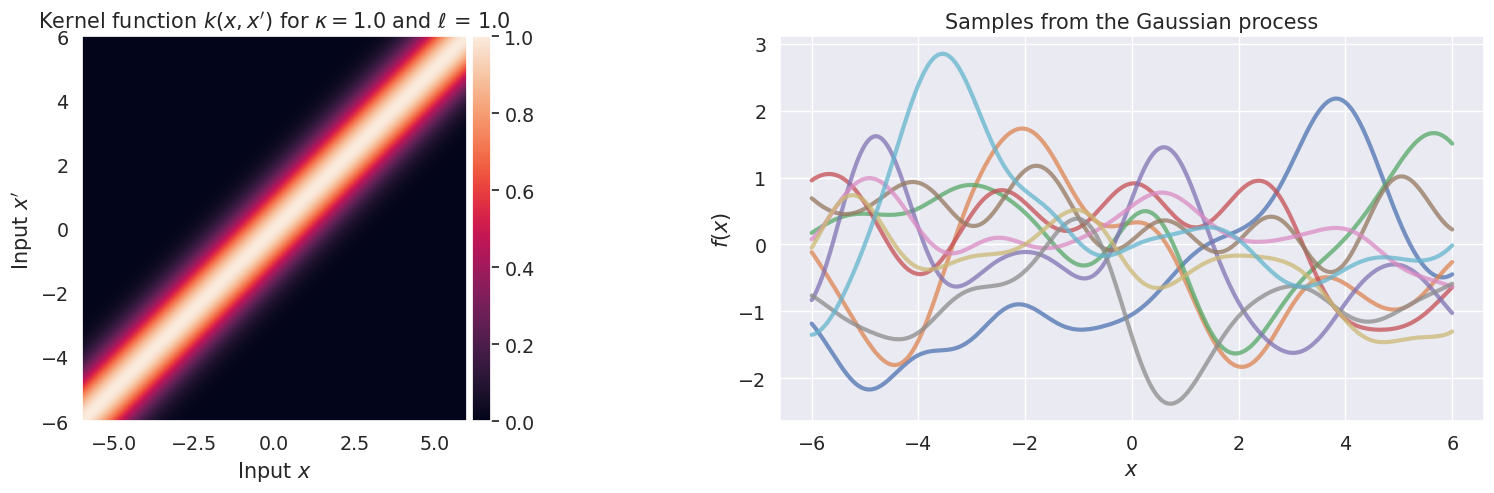

In [82]:
class StationaryIsotropicKernel(object):

    def __init__(self, kernel_fun, kappa=1., lengthscale=1.0):
        """
            the argument kernel_fun must be a function of three arguments kernel_fun(||tau||, kappa, lengthscale), e.g. 
            squared_exponential = lambda tau, kappa, lengthscale: kappa**2*np.exp(-0.5*tau**2/lengthscale**2)
        """
        self.kernel_fun = kernel_fun
        self.kappa = kappa
        self.lengthscale = lengthscale

    def contruct_kernel(self, X1, X2, kappa=None, lengthscale=None, jitter=1e-8):
        """ compute and returns the NxM kernel matrix between the two sets of input X1 (shape NxD) and X2 (MxD) using the stationary and isotropic covariance function specified by self.kernel_fun
    
        arguments:
            X1              -- NxD matrix
            X2              -- MxD matrix
            kappa           -- magnitude (positive scalar)
            lengthscale     -- characteristic lengthscale (positive scalar)
            jitter          -- non-negative scalar
        
        returns
            K               -- NxM matrix    
        """

        # extract dimensions 
        N, M = X1.shape[0], X2.shape[0]

        # prep hyperparameters
        kappa = self.kappa if kappa is None else kappa
        lengthscale = self.lengthscale if lengthscale is None else lengthscale

        ##############################################
        # Your solution goes here
        ##############################################
        taus = jnp.linalg.norm((X1[:,None] - X2), axis = 2)
        K = self.kernel_fun(taus, kappa, lengthscale) + jnp.eye(N, M) * jitter
        ##############################################
        # End of solution
        ##############################################
        
        assert K.shape == (N, M), f"The shape of K appears wrong. Expected shape ({N}, {M}), but the actual shape was {K.shape}. Please check your code. "
        return K

        
# create an Nx1 vector of equidistant points in [-6, 6]
N = 1000
X = jnp.linspace(-6, 6, N)[:, None]

# hyperparameters
kappa = 1.
scale = 1.

# number of samples to be plotted
num_samples = 10

# specify random seed
seed = 1
key = random.PRNGKey(1)

# instantiate kernel object and construct kernel
kernel = StationaryIsotropicKernel(squared_exponential, kappa, scale)
K = kernel.contruct_kernel(X, X)

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

m = jnp.zeros(len(X))
im = ax[0].pcolormesh(X.flatten(), X.flatten(), K, shading='auto')
ax[0].set(xlabel='Input $x$', ylabel="Input $x'$", title=f"Kernel function $k(x, x')$ for $\\kappa = {kappa:2.1f}$ and $\\ell$ = {scale:2.1f}")
ax[0].grid(False)
ax[0].set_aspect('equal')
add_colorbar(im, fig, ax[0])

f_samples = generate_samples(key, m, K, num_samples=num_samples, jitter=1e-8)
ax[1].plot(X, f_samples, alpha=0.75, linewidth=3);
ax[1].grid(True)
ax[1].set(xlabel='$x$', ylabel='$f(x)$', title='Samples from the Gaussian process');


If your code is correct, the cell above you produce a plot of the covariance matrix as well as a plotting a number of samples form the corresponding Gaussian process.

**Task 2.3**: Inspect the plots above. Change the parameters $\kappa, \ell$ and explain how they affect the structure of the kernel (left panel)  [**Discussion question**]

**Task 2.4**: Inspect the plots above. Change the parameters $\kappa, \ell$ and explain how they affect the prior samples (right panel) [**Discussion question**]

**Task 2.5**: Generate samples from the Matern $\frac12$ and Matern $\frac{3}{2}$ kernels. How do they compare to samples from a squared exponential [**Discussion question**]



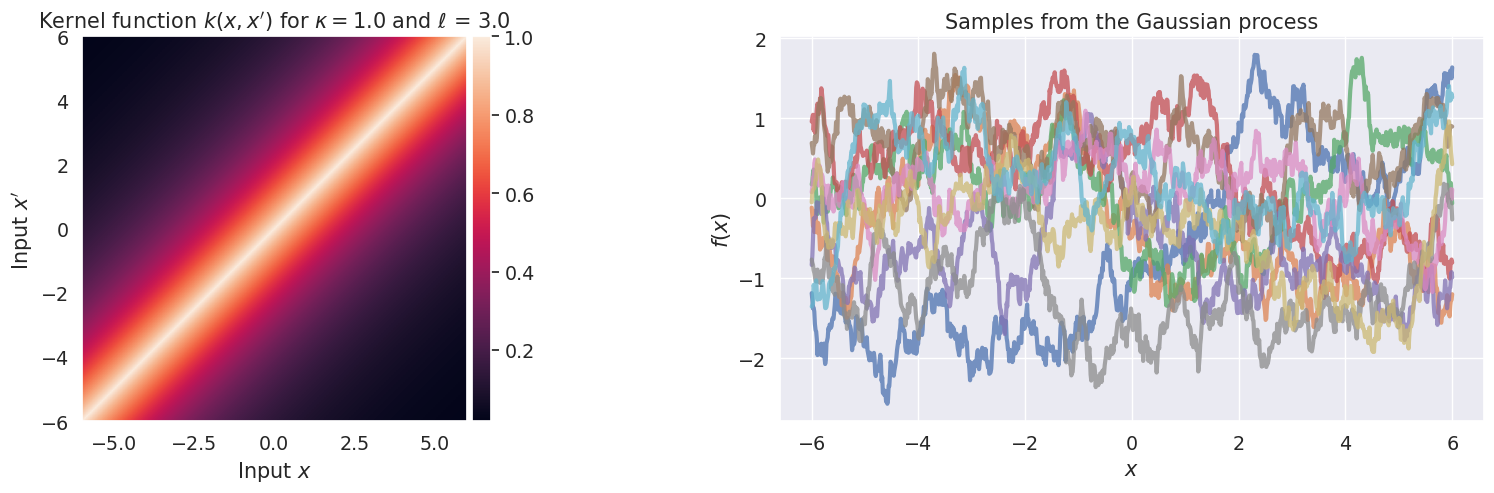

In [83]:
# hyperparameters
kappa = 1.
scale = 3.

# number of samples to be plotted
num_samples = 10

# specify random seed
seed = 1
key = random.PRNGKey(1)

# instantiate kernel object and construct kernel
kernel = StationaryIsotropicKernel(matern12, kappa, scale)
K = kernel.contruct_kernel(X, X)

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

m = jnp.zeros(len(X))
im = ax[0].pcolormesh(X.flatten(), X.flatten(), K, shading='auto')
ax[0].set(xlabel='Input $x$', ylabel="Input $x'$", title=f"Kernel function $k(x, x')$ for $\\kappa = {kappa:2.1f}$ and $\\ell$ = {scale:2.1f}")
ax[0].grid(False)
ax[0].set_aspect('equal')
add_colorbar(im, fig, ax[0])

f_samples = generate_samples(key, m, K, num_samples=num_samples, jitter=1e-8)
ax[1].plot(X, f_samples, alpha=0.75, linewidth=3);
ax[1].grid(True)
ax[1].set(xlabel='$x$', ylabel='$f(x)$', title='Samples from the Gaussian process');


A simple way to understand and compare the three covariance functions (squared exponential, Matérn12, and Matérn32) is to study how they decay as a function of $||\tau|| = ||\mathbf{x}_n - \mathbf{x}_m||$:

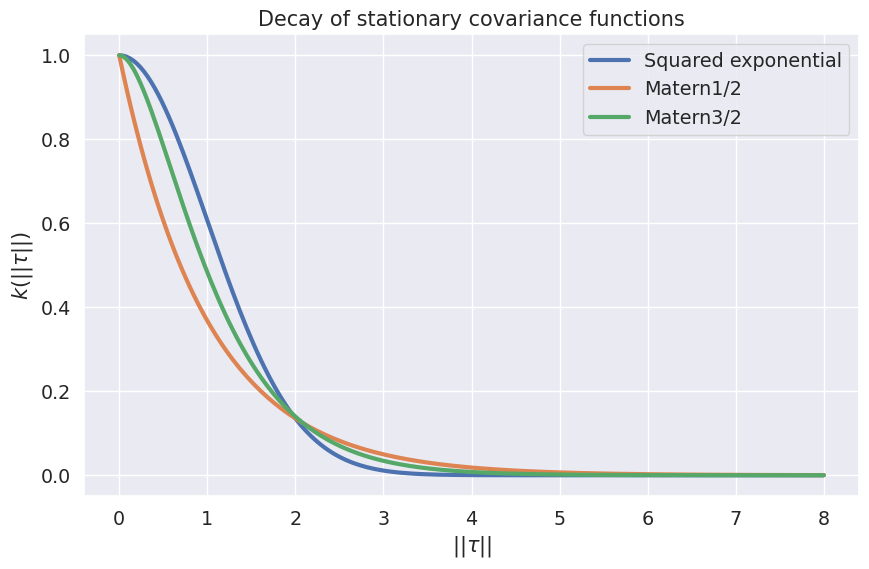

In [84]:
tau = jnp.linspace(0, 8, 200)

kappa = 1
scale = 1

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(tau, squared_exponential(tau, kappa=kappa, lengthscale=scale), linewidth=3, label='Squared exponential')
ax.plot(tau, matern12(tau, kappa=kappa, lengthscale=scale), linewidth=3, label='Matern1/2')
ax.plot(tau, matern32(tau, kappa=kappa, lengthscale=scale), linewidth=3, label='Matern3/2')
ax.set(xlabel='$||\\tau||$', ylabel='$k(||\\tau||)$', title='Decay of stationary covariance functions')
ax.legend()

Suppose the distance between two input points $\mathbf{x}_n$ and $\mathbf{x}_m$ is  $d\cdot \ell$, i.e. $\|\tau\| = \|\mathbf{x}_n - \mathbf{x}_m\| = d\cdot\ell$.

**Task 2.6**: Using the squared exponential covariance function and assume $\kappa = 1$, what is the covariance between the function values $f(\mathbf{x}_n)$ and $f(\mathbf{x}_m)$ for $d = 0, 1, 2, 3, 4, 5$?

*Hints: Use eq. (5)*
\begin{align*}
    & d = 0: \quad \kappa^2 \\
    & d = 1: \quad \kappa^2 \cdod exp(-0.5)\\
    & d = 2: \quad \kappa^2 \cdod exp(-0.5)\\
    & d = 3: \quad \\
    & d = 4: \quad \\
    & d = 5: \quad \\
\end{align*}




In [85]:
d = jnp.array(range(6))
kappa = 1
print(kappa**2 * jnp.exp(-d / 2))

[1.         0.60653066 0.36787944 0.22313016 0.13533528 0.082085  ]


# Part 3:  Non-linear regression using Gaussian processes

In this part, we will study how Gaussian processes can be used for non-linear regression. First, we will study a simple toy data set $\mathcal{D} = \left\lbrace (x_n, y_n) \right\rbrace_{n=1}^N$ for $N = 50$:



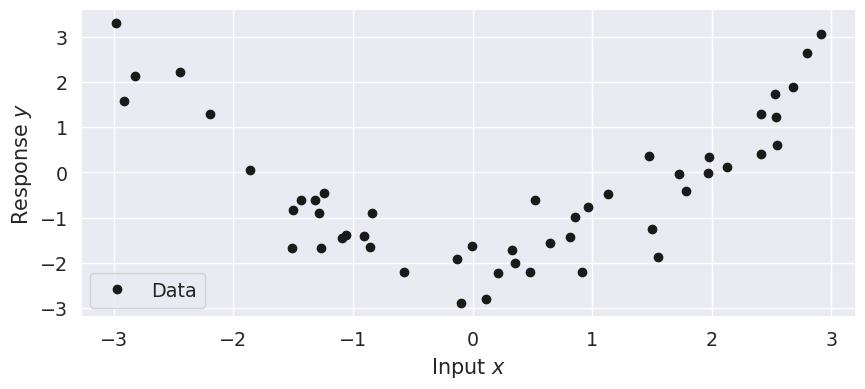

In [86]:
# load data
data = jnp.load('./data_exercise5.npz')
N = data['N']
Xtrain, ytrain = data['X'], data['y']

# for predictions
Xstar = jnp.linspace(-3, 9, 100)[:, None]

# function for plotting
def plot_data(ax):
    ax.plot(Xtrain, ytrain, 'k.', markersize=12, label='Data')
    ax.grid(True)
    ax.set_xlabel('Input $x$')
    ax.set_ylabel('Response $y$')
    ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_data(ax)


We will adopt the following model

$$
\begin{align*}
y_n = f(\mathbf{x}_n) + e_n,
\end{align*}
$$

where $f(\mathbf{x})$ is assumed to be a Gaussian process. Assuming the noise $e_n$ is i.i.d. and Gaussian, the joint model for the training data becomes:

\begin{align*}
p(\mathbf{y}, \mathbf{f}) = \mathcal{N}\left(\mathbf{y}|\mathbf{f}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{f} | \mathbf{0}, \mathbf{K}\right)
\end{align*}

where $\mathbf{K}_{nm} = k(\mathbf{x}_n, \mathbf{x}_m)$ is the covariance matrix. 
We will also use the squared exponential and Matérn covariance functions in this part. Thus, this model (when using these covariance functions) has three hyperparameters in total: $\mathbf{\theta} = \left\lbrace \sigma, \kappa, \ell\right\rbrace$, where 

- $\sigma > 0$ is the standard deviation of the noise, 

- $\kappa > 0$ is the magnitude of the kernel,

- $\ell > 0$ is the lengthscale of the kernel. 

We will use $\mathbf{\theta}_K = \left\lbrace \kappa, \ell\ \right\rbrace$ to denote the hyperparameters of the kernel $K$ and $\mathbf{\theta}$ to denote all hyperparameters of the model.



Below you are given an incomplete implementation of a class for Gaussian process regression. The function called **compute_posterior** is supposed to the posterior mean and covariance matrix of the function values $f(\mathbf{x}^*)$ for input $\mathbf{x}^*$ conditioned on the training data $\mathbf{y}$.
The class contains a template for the following functions:

- `predict_f`: computes the posterior distribution of the function value $f(\mathbf{x}^*)$ for a new input, $\mathbf{x}^*$, i.e. $p(f^*|\mathbf{y}) = \mathcal{N}(f^*|\mu_{f^*}, \Sigma_{f^*})$
- `predict_y`: computes the posterior predictive distribution of for a new observation at new input, $\mathbf{x}^*$, i.e. $p(y^*|\mathbf{y}) = \mathcal{N}(y^*|\mu_{y^*}, \Sigma_{y^*})$
- `posterior_samples`: generates samples from the posterior distribution of $f^*$ for a set of inputs, i.e. $\mathbf{f}^* \sim p(f^*|\mathbf{y})$
- `log_marginal_likelihood`: evaluate the log marginal likelihood for a given set if hyperparameters $\theta$

In this part, we will focus on the first three and then come back to the marginal likelihood later.

**Task 3.1**: Complete the implementation of the function `predict_f` below.

*Hints*:
- *Look at eq. (17.34), (17.35) and (17.36) in Murphy1*
- *For computing matrix-vector prodcuts of the form $\mathbf{A}^{-1} \mathbf{x}$, `np.linalg.solve(A, x)` is numerically much more stable than `np.linalg.inv(A)@x`*.
- *If you prefer, you can move the class to a separate python module and import it to the notebook if you prefer not the scroll up and down during as you make it through the notebook*.




**Task 3.2**: Complete the implementation of the function `predict_y` below.

*Hints: Use the function `predict_f` you implemented in the previous task to do most of the work*

**Task 3.3**: Complete the implementation of the function `posterior_samples` below.

*Hints: The implementation of this should be easy and make heavy use of functions you already implemented*



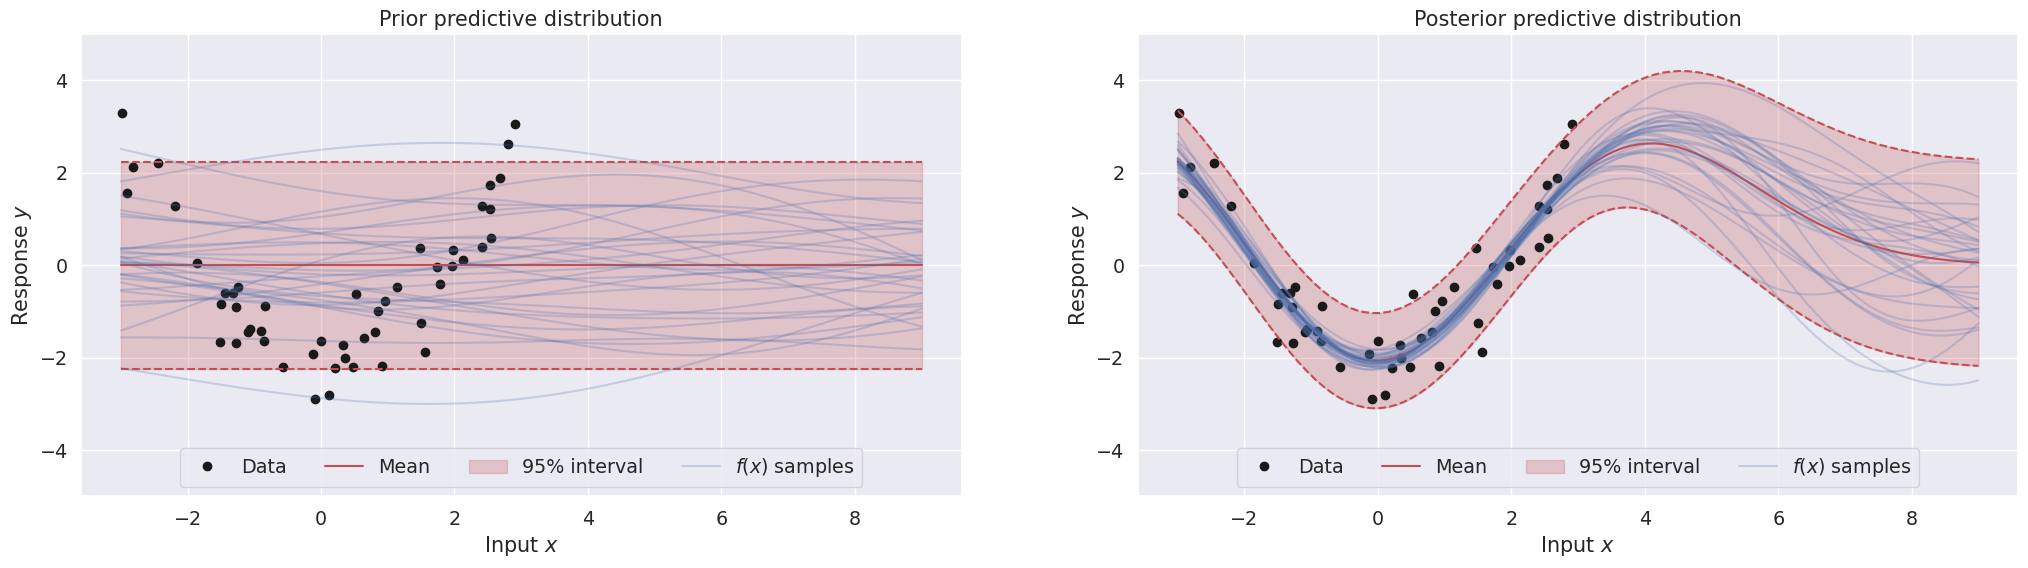

In [87]:
def plot_with_uncertainty(ax, Xp, gp, color='r', color_samples='b', title="", num_samples=0, seed=0):
    
    mu, Sigma = gp.predict_y(Xp)
    mean = mu.ravel()
    std = jnp.sqrt(jnp.diag(Sigma))

    # random seed
    key = random.PRNGKey(seed)

    # plot distribution
    ax.plot(Xp, mean, color=color, label='Mean')
    ax.plot(Xp, mean + 2*std, color=color, linestyle='--')
    ax.plot(Xp, mean - 2*std, color=color, linestyle='--')
    ax.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25, label='95% interval')
    
    # generate samples
    if num_samples > 0:
        fs = gp.posterior_samples(key, Xstar, num_samples)
        ax.plot(Xp, fs[:,0], color=color_samples, alpha=.25, label="$f(x)$ samples")
        ax.plot(Xp, fs[:, 1:], color=color_samples, alpha=.25)
    
    ax.set_title(title)
    



class GaussianProcessRegression(object):

    def __init__(self, X, y, kernel, kappa=1., lengthscale=1., sigma=1/2, jitter=1e-8):
        """  
        Arguments:
            X                -- NxD input points
            y                -- Nx1 observed values 
            kernel           -- must be instance of the StationaryIsotropicKernel class
            jitter           -- non-negative scaler
            kappa            -- magnitude (positive scalar)
            lengthscale      -- characteristic lengthscale (positive scalar)
            sigma            -- noise std. dev. (positive scalar)
        """
        self.X = X
        self.y = y
        self.N = len(X)
        self.kernel = kernel
        self.jitter = jitter
        self.set_hyperparameters(kappa, lengthscale, sigma)
        self.check_dimensions()

    def check_dimensions(self):
        assert self.X.ndim == 2, f"The variable X must be of shape (N, D), however, the current shape is: {self.X.shape}"
        N, D = self.X.shape

        assert self.y.ndim == 2, f"The varabiel y must be of shape (N, 1), however. the current shape is: {self.y.shape}"
        assert self.y.shape == (N, 1), f"The varabiel y must be of shape (N, 1), however. the current shape is: {self.y.shape}"
        

    def set_hyperparameters(self, kappa, lengthscale, sigma):
        self.kappa = kappa
        self.lengthscale = lengthscale
        self.sigma = sigma

    def posterior_samples(self, key, Xstar, num_samples):
        """
            generate samples from the posterior p(f^*|y, x^*) for each of the inputs in Xstar

            Arguments:
                key              -- jax random key for controlling the random number generator
                Xstar            -- PxD prediction points
        
            returns:
                f_samples        -- numpy array of (P, num_samples) containing num_samples for each of the P inputs in Xstar
        """
        ##############################################
        # Your solution goes here
        ##############################################
        mu, Sigma = self.predict_f(Xstar)

        f_samples = generate_samples(key = key,
                                     m = mu.squeeze(axis=-1),
                                     K = Sigma,
                                     num_samples = num_samples)
        ##############################################
        # End of solution
        ##############################################

        assert (f_samples.shape == (len(Xstar), num_samples)), f"The shape of the posterior mu seems wrong. Expected ({len(Xstar)}, {num_samples}), but actual shape was {f_samples.shape}. Please check implementation"
        return f_samples
        
    def predict_y(self, Xstar):
        """ returns the posterior distribution of y^* evaluated at each of the points in x^* conditioned on (X, y)
        
        Arguments:
        Xstar            -- PxD prediction points
        
        returns:
        mu               -- Px1 mean vector
        Sigma            -- PxP covariance matrix
        """
        ...
        ##############################################
        # Your solution goes here
        ##############################################
        mu, Sigma_f = self.predict_f(Xstar)
        Sigma = Sigma_f + jnp.identity(len(Sigma_f)) * self.sigma**2
        ##############################################
        # End of solution
        ##############################################

        return mu, Sigma

    def predict_f(self, Xstar):
        """ returns the posterior distribution of f^* evaluated at each of the points in x^* conditioned on (X, y)
        
        Arguments:
        Xstar            -- PxD prediction points
        
        returns:
        mu               -- Px1 mean vector
        Sigma            -- PxP covariance matrix
        """

        ##############################################
        # Your solution goes here
        ##############################################
        P,D = Xstar.shape
        N = self.X.shape[0]

        XXstar = jnp.vstack((self.X, Xstar))

        K = self.kernel.contruct_kernel(XXstar, XXstar,
                                        lengthscale = self.lengthscale,
                                        kappa = self.kappa)

        K_sigma = K[:N, :N] + jnp.identity(N) * self.sigma**2
        Kxstar = K[:N, N:]
        Kstarstar = K[N:, N:] 

        mu =  Kxstar.T @ jnp.linalg.solve(K_sigma, self.y )

        Sigma = Kstarstar - Kxstar.T @ jnp.linalg.solve(K_sigma, Kxstar)

        ##############################################
        # End of solution
        ##############################################
        pass
        # sanity check for dimensions
        assert (mu.shape == (len(Xstar), 1)), f"The shape of the posterior mu seems wrong. Expected ({len(Xstar)}, 1), but actual shape was {mu.shape}. Please check implementation"
        assert (Sigma.shape == (len(Xstar), len(Xstar))), f"The shape of the posterior Sigma seems wrong. Expected ({len(Xstar)}, {len(Xstar)}), but actual shape was {Sigma.shape}. Please check implementation"

        return mu, Sigma
    
    def log_marginal_likelihood(self, kappa, lengthscale, sigma):
        """ 
            evaluate the log marginal likelihood p(y) given the hyperparaemters 

            Arguments:
            kappa       -- positive scalar 
            lengthscale -- positive scalar
            sigma       -- positive scalar
            """

        ##############################################
        # Your solution goes here
        ##############################################
        K = self.kernel.contruct_kernel(self.X, self.X,
                                        lengthscale = lengthscale,
                                        kappa = kappa)

        K_sigma = K + jnp.identity(self.N) * sigma**2
        L = jnp.linalg.cholesky(K_sigma)

        log_det = jnp.sum(jnp.log(jnp.diag(L)))

        v = jnp.linalg.solve(L, self.y)
        mprod = 0.5*jnp.sum(v**2)
        cons = -0.5 * self.N * jnp.log(2 * jnp.pi)

        log_marg_lik = cons - log_det - mprod
     
        return log_marg_lik

        ##############################################
        # End of solution
        ##############################################

    
        
# instantiate kernel
kernel = StationaryIsotropicKernel(kernel_fun=squared_exponential)

# instantiate GP without data (hence, posterior=prior) and with data
gp_prior = GaussianProcessRegression(jnp.zeros((0, 1)), jnp.zeros((0, 1)), kernel, lengthscale=5)
gp_post = GaussianProcessRegression(Xtrain, ytrain, kernel, lengthscale=2, kappa = 1)
# gp_post.predict_f(Xstar)

# plot
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
plot_data(ax[0])
plot_with_uncertainty(ax[0], Xstar, gp_prior, title='Prior predictive distribution', num_samples=30)
ax[0].legend(loc='lower center', ncol=4)
ax[0].set_ylim((-5, 5))

plot_data(ax[1])
plot_with_uncertainty(ax[1], Xstar, gp_post, title='Posterior predictive distribution', num_samples=30)
ax[1].legend(loc='lower center', ncol=4)
ax[1].set_ylim((-5, 5));

If the code has been implemented correct, then the left figure above shows 30 samples from the prior predictive distribution along with the mean and 95% interval from the prior predictive distribution, whereas the right figure shows the same quantities for the posterior predictive distribution.

**Task 3.4**: Inspect the plots above. How does the prior and posterior predictive differ in: a) regions close to the data points? b) in regions far from the data point? [**Discussion question**]


**Task 3.5**: Explain this behavior using the equations for the posterior mean and covariance of $f^*$ (and what you saw in part 2)? [**Discussion question**]


**Task 3.6**: Visualize the prior covariance matrix for $f^*$ and posterior covariance for $f^*$ matrix side-by-side as images and comment on what you see



Text(0.5, 1.0, 'Posterior')

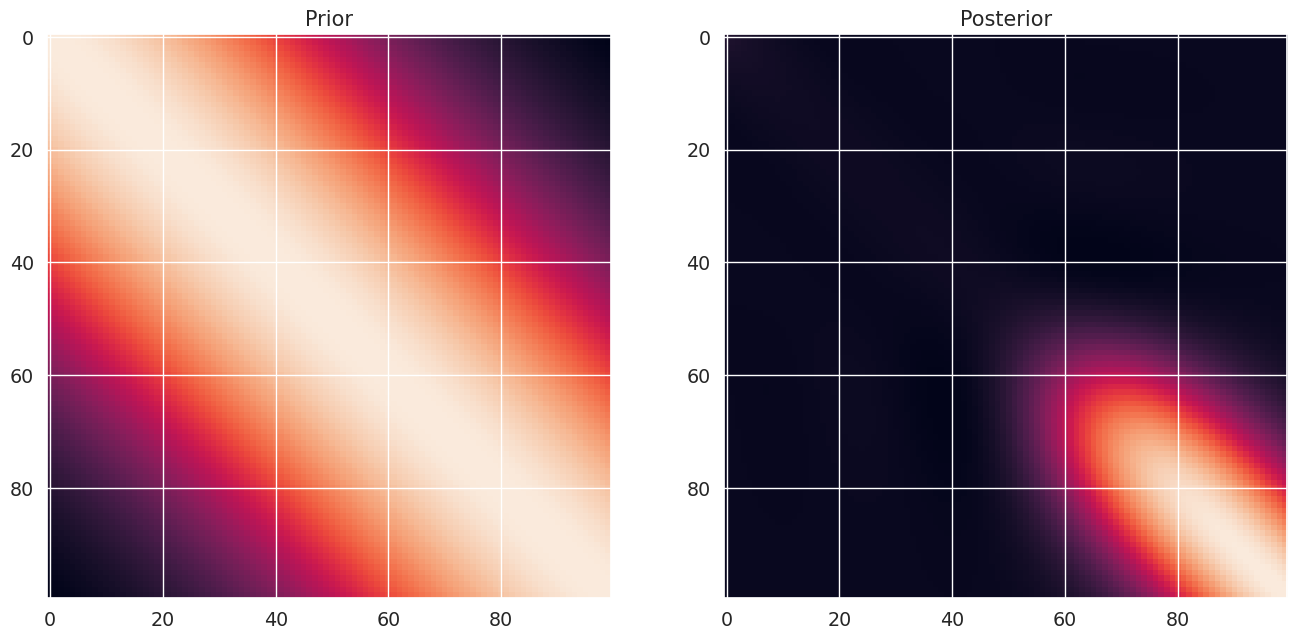

In [88]:
_, Sigma_prior = cov_prior = gp_prior.predict_f(Xstar)
_, Sigma_post = cov_post = gp_post.predict_f(Xstar)

fig, ax = plt.subplots(1,2, figsize = (16, 8))
ax[0].imshow(Sigma_prior)
ax[0].set_title("Prior")
ax[1].imshow(Sigma_post)
ax[1].set_title("Posterior")


**Task 3.7**: Change the values of kappa and scale and explain how it affects the prior and posterior. For example, what happens if you choose the lengthscale $\ell$ to be either 0.25, 1, or 5 while keeping $\kappa = 1$ and $\sigma = \frac12$? Do similar experiments with $\sigma$ and $\kappa$. [**Discussion question**]







**Task 3.8**: Experiment with the two other kernerls, the Matérn $\frac12$ and the Matérn $\frac{3}{2}$. How does that affect the fits and the predictions? [**Discussion question**]


Text(0.5, 1.0, 'Posterior Mattern 1/2')

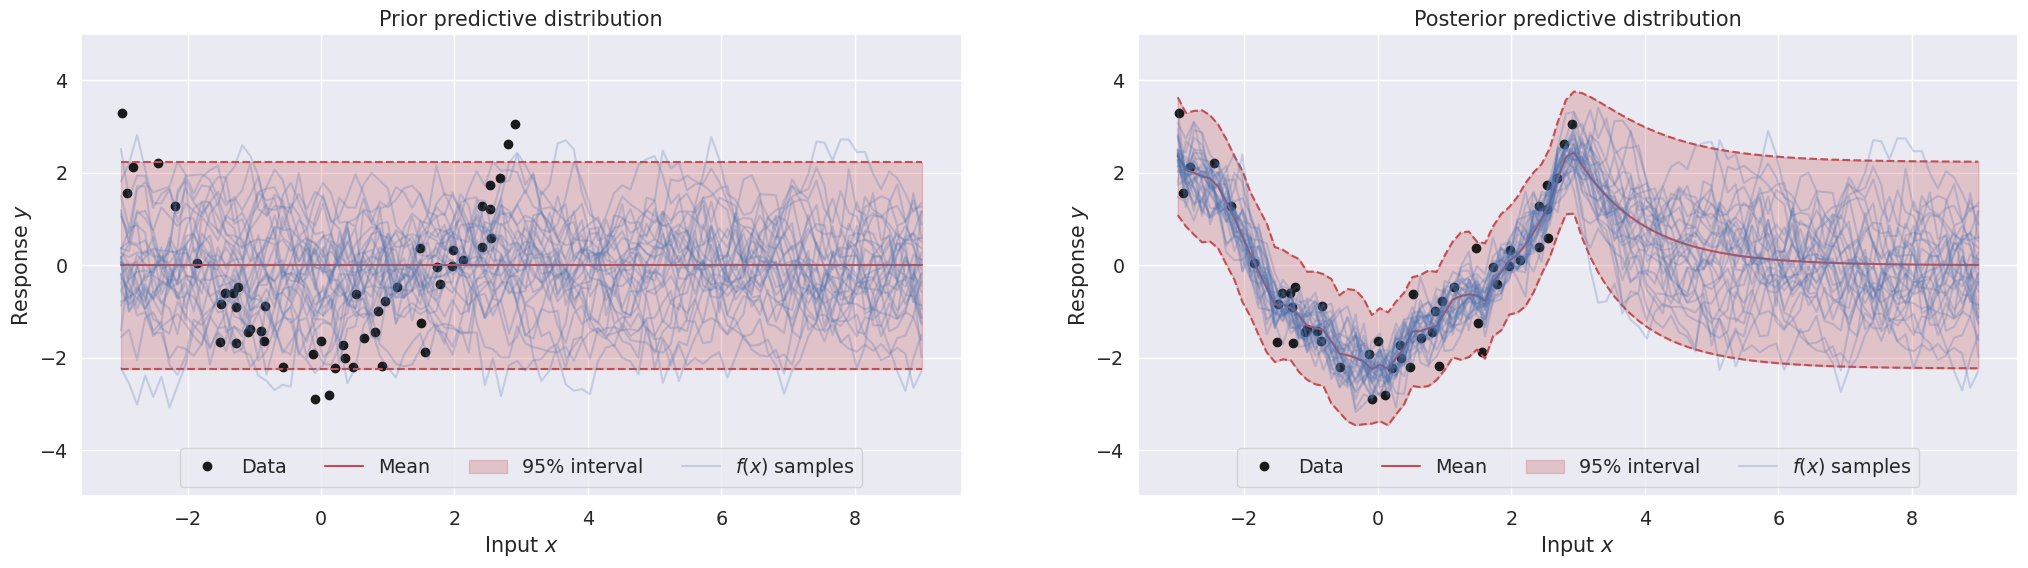

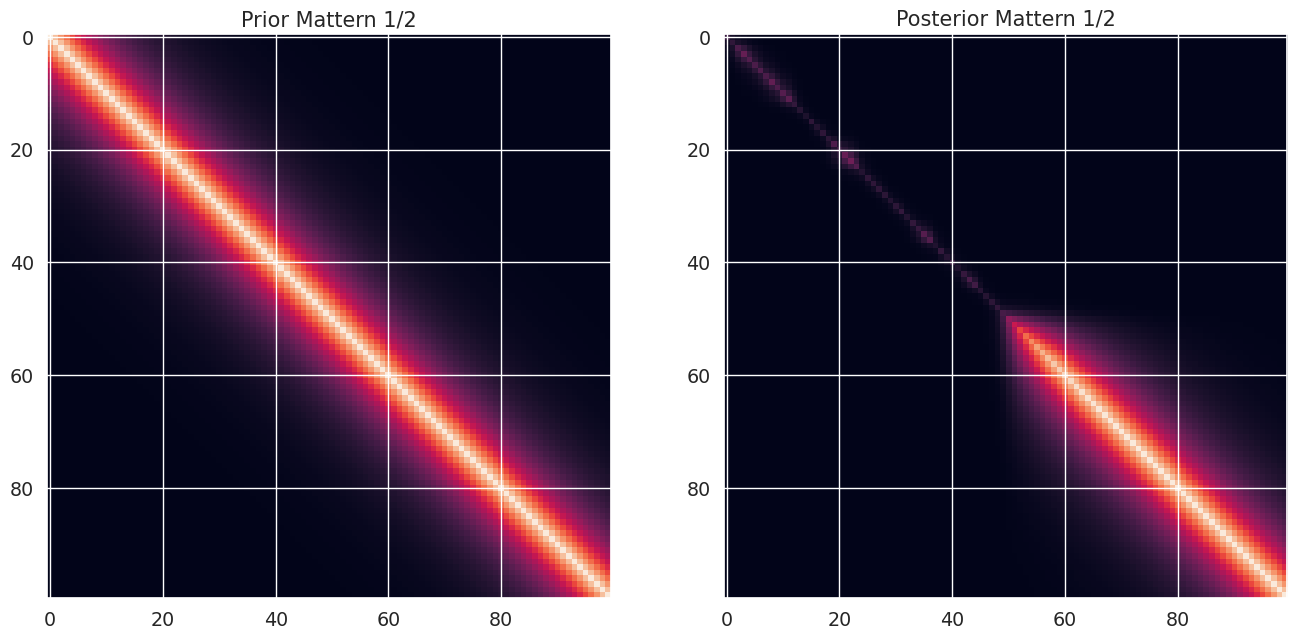

In [89]:
# instantiate kernel
kernel = StationaryIsotropicKernel(kernel_fun=matern12)

# instantiate GP without data (hence, posterior=prior) and with data
gp_prior = GaussianProcessRegression(jnp.zeros((0, 1)), jnp.zeros((0, 1)), kernel)
gp_post = GaussianProcessRegression(Xtrain, ytrain, kernel)
# gp_post.predict_f(Xstar)

# plot
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
plot_data(ax[0])
plot_with_uncertainty(ax[0], Xstar, gp_prior, title='Prior predictive distribution', num_samples=30)
ax[0].legend(loc='lower center', ncol=4)
ax[0].set_ylim((-5, 5))

plot_data(ax[1])
plot_with_uncertainty(ax[1], Xstar, gp_post, title='Posterior predictive distribution', num_samples=30)
ax[1].legend(loc='lower center', ncol=4)
ax[1].set_ylim((-5, 5));

_, Sigma_prior = cov_prior = gp_prior.predict_f(Xstar)
_, Sigma_post = cov_post = gp_post.predict_f(Xstar)

fig, ax = plt.subplots(1,2, figsize = (16, 8))
ax[0].imshow(Sigma_prior)
ax[0].set_title("Prior Mattern 1/2")
ax[1].imshow(Sigma_post)
ax[1].set_title("Posterior Mattern 1/2")

Text(0.5, 1.0, 'Posterior Mattern 3/2')

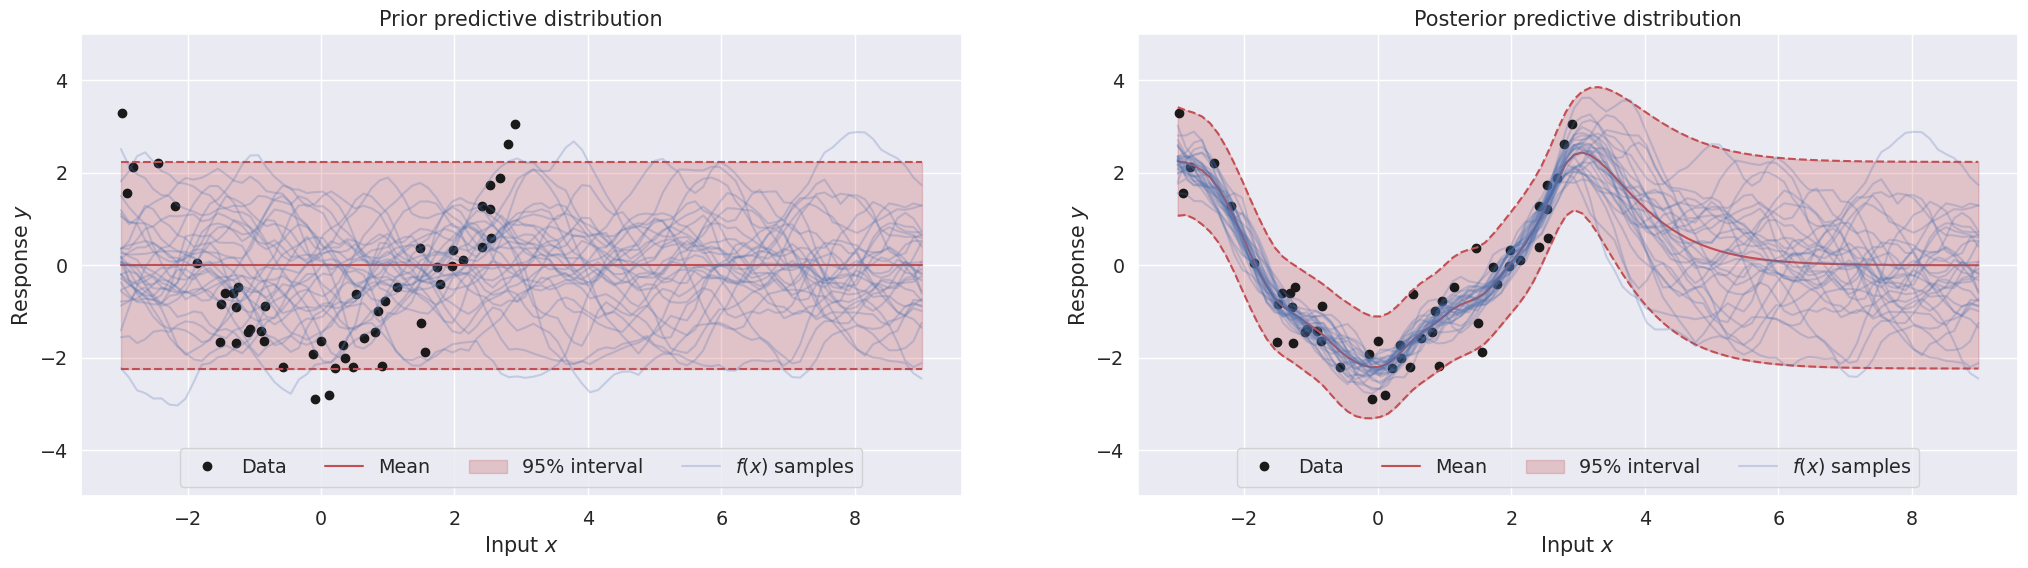

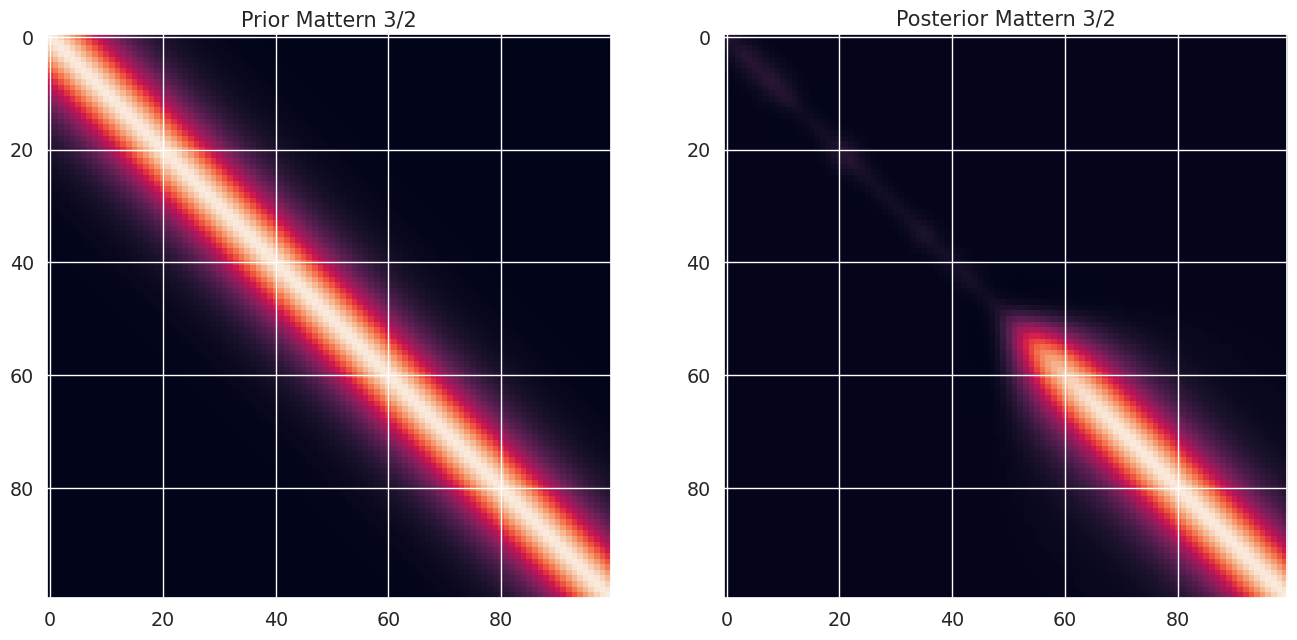

In [90]:
# instantiate kernel
kernel = StationaryIsotropicKernel(kernel_fun=matern32)

# instantiate GP without data (hence, posterior=prior) and with data
gp_prior = GaussianProcessRegression(jnp.zeros((0, 1)), jnp.zeros((0, 1)), kernel)
gp_post = GaussianProcessRegression(Xtrain, ytrain, kernel)
# gp_post.predict_f(Xstar)

# plot
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
plot_data(ax[0])
plot_with_uncertainty(ax[0], Xstar, gp_prior, title='Prior predictive distribution', num_samples=30)
ax[0].legend(loc='lower center', ncol=4)
ax[0].set_ylim((-5, 5))

plot_data(ax[1])
plot_with_uncertainty(ax[1], Xstar, gp_post, title='Posterior predictive distribution', num_samples=30)
ax[1].legend(loc='lower center', ncol=4)
ax[1].set_ylim((-5, 5));

_, Sigma_prior = cov_prior = gp_prior.predict_f(Xstar)
_, Sigma_post = cov_post = gp_post.predict_f(Xstar)

fig, ax = plt.subplots(1,2, figsize = (16, 8))
ax[0].imshow(Sigma_prior)
ax[0].set_title("Prior Mattern 3/2")
ax[1].imshow(Sigma_post)
ax[1].set_title("Posterior Mattern 3/2")

# Part 4:  Hyperparameter optimization using the marginal likelihood

Before we can apply this model in practice, we will study how we can use the ***marginal likelihood*** to estimate the hyperparameters of the model. If we let $\mathbf{\theta} \in \mathbb{R}^K$ denote all of our hyperparameters, then the **evidence approximation** suggests that we can estimate $\mathbf{\theta}$ as follows

\begin{align*}
\hat{\mathbf{\theta}} = \arg\max\limits_{\mathbf{\theta}} \ln p(\mathbf{y}|\mathbf{\theta}),
\end{align*}

where $p(\mathbf{y}|\mathbf{\theta})$ is the marginal likelihood of the model (see eq. (17.52) in Murphy1).


**Task 4.1**: Go back up to the implementation of `GaussianProcessRegression`-class and complete the implementation of the function `log_marginal_likelihood`

- *Hints: The expression for the marginal likelihood contains both determinants and matrix inverse, which can be numerically fragile and lead to underflow/overflow. Hence, you need to be careful with the numerical implementation. See the details in the slides for this week*

If your implementation is correct, then the code below implement an optimization routine for the marginal likelihood. Note that we re-parametrize the hyperparameters in the log-domain before optimizing to ensure that the hyperparameter remain positive. We rely and the package `autograd` for computing the gradients.

In [91]:
def optimize_hyperparameters(gp, theta_init):

    # define optimization objective as the negative log marginal likelihood
    objective = lambda params: -gp.log_marginal_likelihood(jnp.exp(params[0]), jnp.exp(params[1]), jnp.exp(params[2]))

    # optimize using gradients
    res = minimize(value_and_grad(objective), jnp.log(theta_init), jac=True)

    # check for success
    if not res.success:
        print('Warning: optimization failed!')

    # return resultss
    theta = jnp.exp(res.x)
    return theta


Let's run it on our toy dataset:

Estimated hyperparameters
	sigma: 0.59
	kappa: 2.92
	scale: 1.82


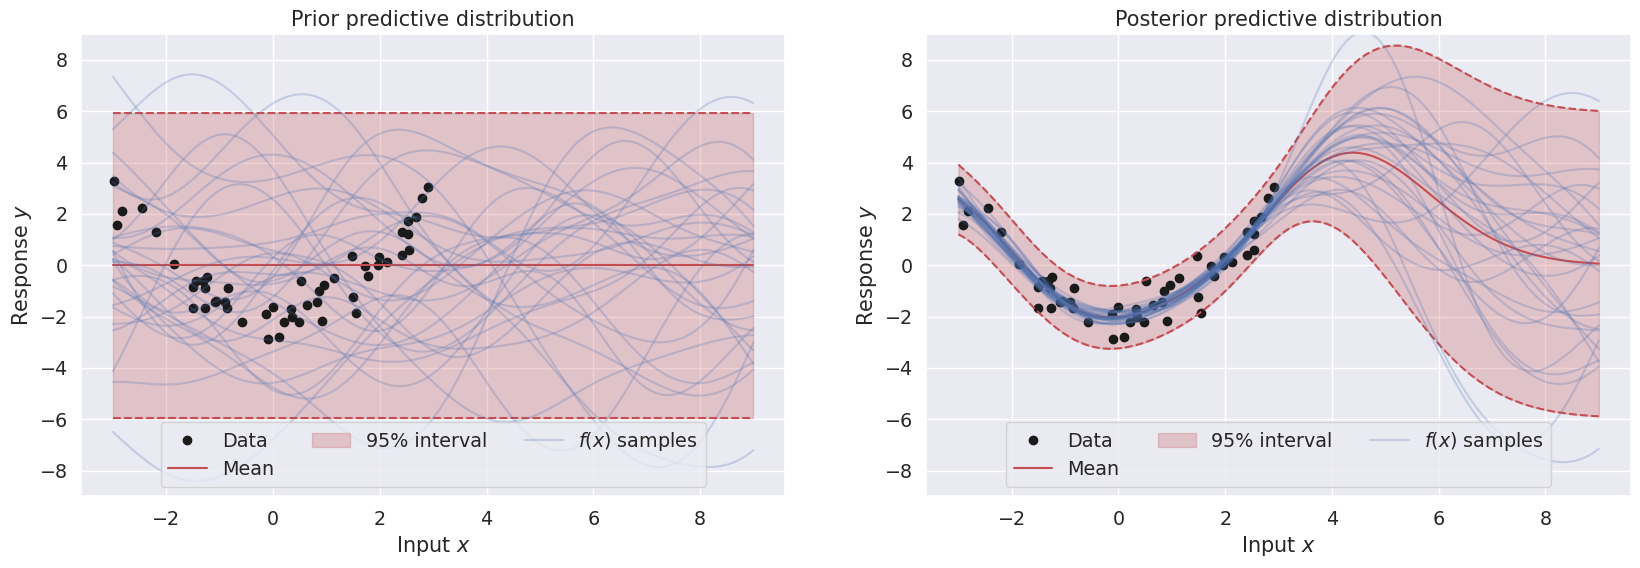

In [92]:
kernel = StationaryIsotropicKernel(kernel_fun=squared_exponential)
gp_prior = GaussianProcessRegression(jnp.zeros((0, 1)), jnp.zeros((0, 1)), kernel)
gp_post = GaussianProcessRegression(Xtrain, ytrain, kernel)

# optimize
theta_hat = optimize_hyperparameters(gp_post, theta_init=jnp.array([1,1,1]))

# extract individual hyperparameters
kappa_hat, scale_hat, sigma_hat = theta_hat

# print
print('Estimated hyperparameters')
print(f'\tsigma: {sigma_hat:3.2f}')
print(f'\tkappa: {kappa_hat:3.2f}')
print(f'\tscale: {scale_hat:3.2f}')


gp_prior = GaussianProcessRegression(jnp.zeros((0, 1)), jnp.zeros((0, 1)), kernel)
gp_post = GaussianProcessRegression(Xtrain, ytrain, kernel)
gp_prior.set_hyperparameters(kappa_hat, scale_hat, sigma_hat)
gp_post.set_hyperparameters(kappa_hat, scale_hat, sigma_hat)

mu_prior, Sigma_prior = gp_prior.predict_f(Xstar)
mu_post, Sigma_post = gp_post.predict_f(Xstar)
    
# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_data(ax[0])
plot_with_uncertainty(ax[0], Xstar, gp_prior, title='Prior predictive distribution', num_samples=30)
ax[0].legend(loc='lower center', ncol=3)
ax[0].set_ylim((-9, 9))
plot_data(ax[1])
plot_with_uncertainty(ax[1], Xstar, gp_post, title='Posterior predictive distribution', num_samples=30)
ax[1].legend(loc='lower center', ncol=3)
ax[1].set_ylim((-9, 9));

**Task 4.2**: Comment on the quality of the fit. Does it seem reasonable? [**Discussion question**]





**Task 4.3**: If we were to fit the three hyperparameters using 5-fold cross-validation and a grid search rather than using the marginal likelihood, how many times would we have to train the model? Assume we would 10 different values for each hyperparameter.



# Part 5:  Analysing the bike sharing data set

In this section, your task is to fit a GP regression model (with squared exponential kernel) to a subset of the bike sharing dataset (Source: [https://ride.capitalbikeshare.com/system-data](https://ride.capitalbikeshare.com/system-data)). The dataset consists of the number of rented bikes in 2011.

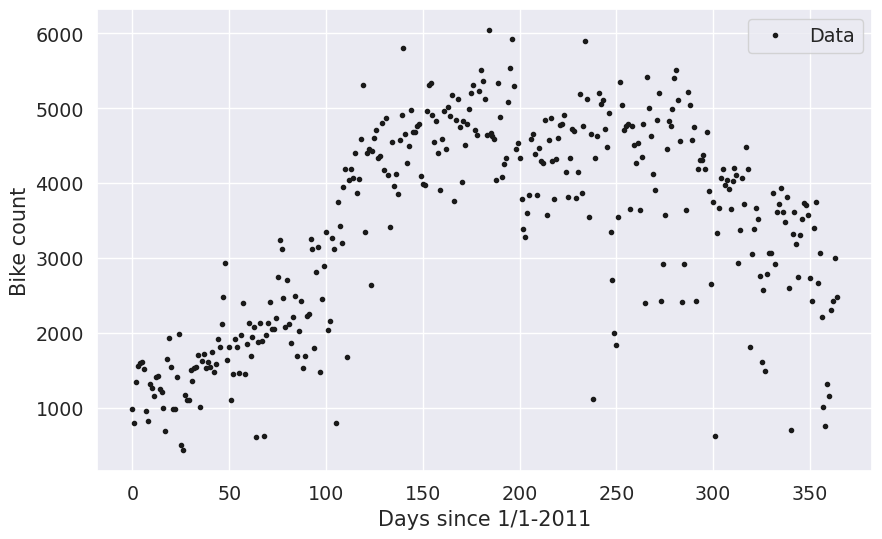

In [93]:
data = jnp.load('./data_exercise5b.npz')
day = data['day']
bike_count = data['bike_count']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(day, bike_count, 'k.', label='Data')
ax.legend()
ax.set(xlabel='Days since 1/1-2011', ylabel='Bike count');


**Task 5.1**: Log-transform the bike counts, remove the mean and scale to unit variance. Plot the preprocessed data set.



**Task 5.2**: Estimate the hyperparameters of a Gaussian process regression model with a squared exponential kernel from the preprocessed data. Report the estimated values of each hyperparameter.



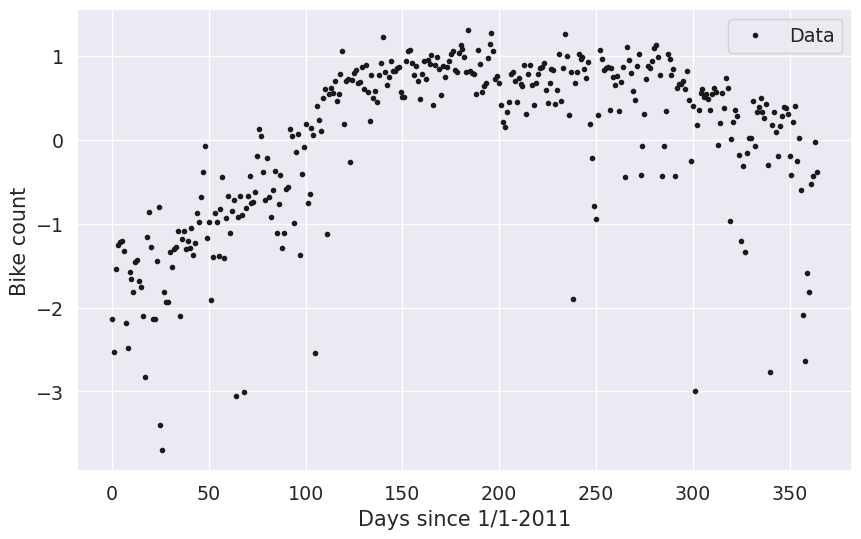

In [94]:
log_data = jnp.log(bike_count)
log_data = (log_data - jnp.mean(log_data)) / jnp.std(log_data)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(day, log_data, 'k.', label='Data')
ax.legend()
ax.set(xlabel='Days since 1/1-2011', ylabel='Bike count');

In [102]:
kernel = StationaryIsotropicKernel(kernel_fun=squared_exponential)
n = 50
ytrain = log_data[:n]
xtrain = day[:n]
ytest = log_data[n:]
xtest = day[n:]

# instantiate GP without data (hence, posterior=prior) and with data
gp_prior = GaussianProcessRegression(jnp.zeros((0, 1)), jnp.zeros((0, 1)), kernel, lengthscale=1)
gp_post = GaussianProcessRegression(day, log_data, kernel, lengthscale=2, kappa = 1)
theta_hat = optimize_hyperparameters(gp_post, theta_init=jnp.array([1,1,1]))

# extract individual hyperparameters
kappa_hat, scale_hat, sigma_hat = theta_hat
gp = GaussianProcessRegression(day, log_data, kernel)
gp.set_hyperparameters(kappa_hat, scale_hat, sigma_hat)

# print
print('Estimated hyperparameters')
print(f'\tsigma: {sigma_hat:3.2f}')
print(f'\tkappa: {kappa_hat:3.2f}')
print(f'\tscale: {scale_hat:3.2f}')




Estimated hyperparameters
	sigma: 0.57
	kappa: 1.08
	scale: 78.63


(0.0, 364.0)

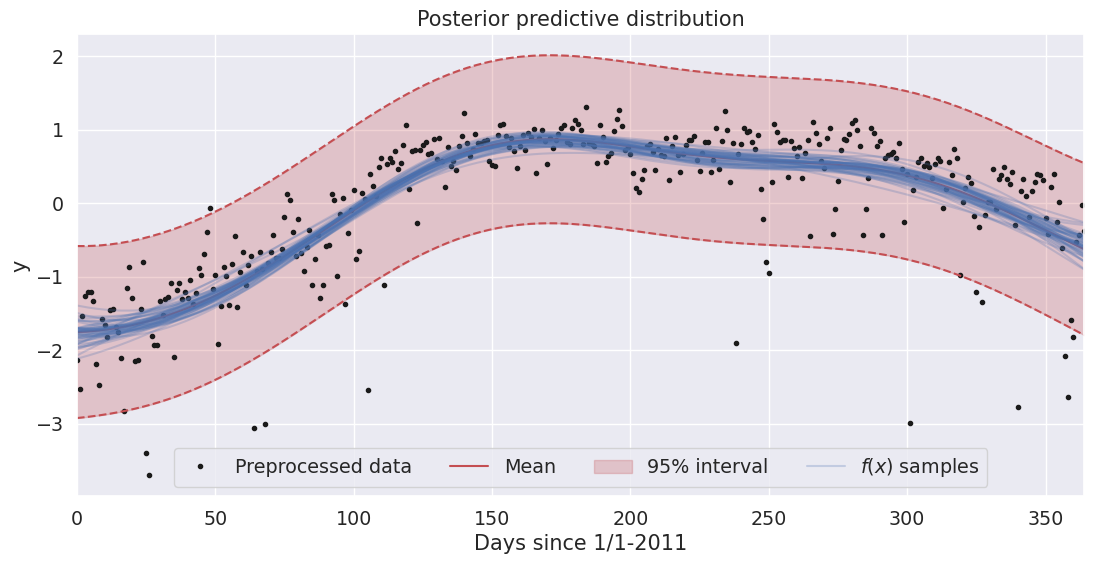

In [104]:
# days for predictions
Xstar = jnp.arange(0, 370)[:, None]
X = day
y = log_data
# compute posterior of y for all days in interval [0, 370]
mu_post, Sigma_post = gp.predict_f(Xstar)

# visualize
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
ax.plot(X, y, 'k.', label='Preprocessed data')
plot_with_uncertainty(ax, Xstar, gp, title='Posterior predictive distribution', num_samples=50)
ax.legend(loc='lower center', ncol=4)
ax.set(xlabel='Days since 1/1-2011', ylabel='y')
ax.set_xlim(X.min(), X.max())